# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



In [1]:
# 1. Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [36]:
# 2. Load Dataset
data = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [37]:
# 3. Data Overview
print("Data Shape:", data.shape)
print("\nData Sample:")
print(data.head())


Data Shape: (41188, 21)

Data Sample:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx 

In [38]:
# 4. Encode Categorical Features
categorical_cols = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    if col != 'y':
        data[col] = le.fit_transform(data[col])

# Convert target variable 'y' to binary
data['y'] = data['y'].map({'yes': 1, 'no': 0})

In [39]:
# 5. Split Data
X = data.drop('y', axis=1)
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [40]:
# 6. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
# 7. Model Training
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score: {auc:.4f}")
    
    results[name] = {
        'model': model,
        'auc': auc,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': cm
    }



Training Logistic Regression...
[[10698   267]
 [  837   555]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10965
           1       0.68      0.40      0.50      1392

    accuracy                           0.91     12357
   macro avg       0.80      0.69      0.73     12357
weighted avg       0.90      0.91      0.90     12357

ROC-AUC Score: 0.9323

Training K-Nearest Neighbors...
[[10596   369]
 [  852   540]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10965
           1       0.59      0.39      0.47      1392

    accuracy                           0.90     12357
   macro avg       0.76      0.68      0.71     12357
weighted avg       0.89      0.90      0.89     12357

ROC-AUC Score: 0.8579

Training Decision Tree...
[[10265   700]
 [  693   699]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10965
       

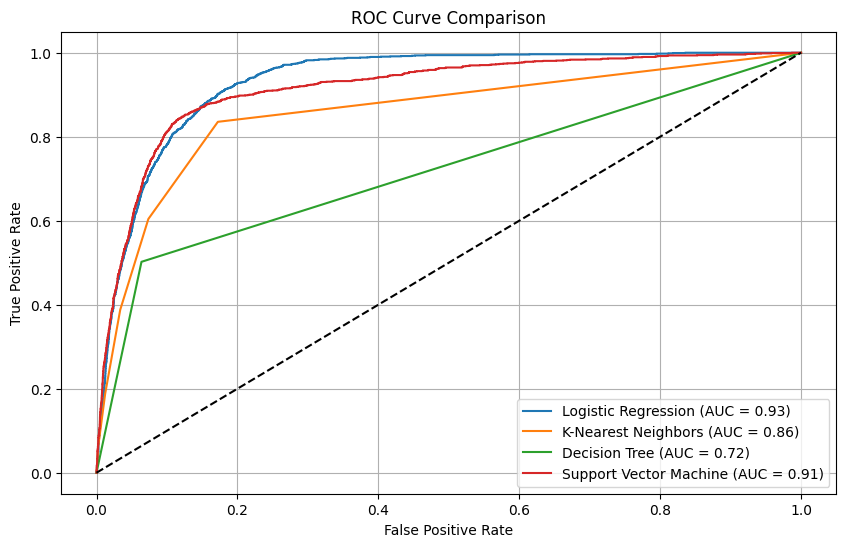

In [42]:

# 8. Visualize ROC Curves
plt.figure(figsize=(10, 6))
for name, result in results.items():
    y_proba = result['model'].predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


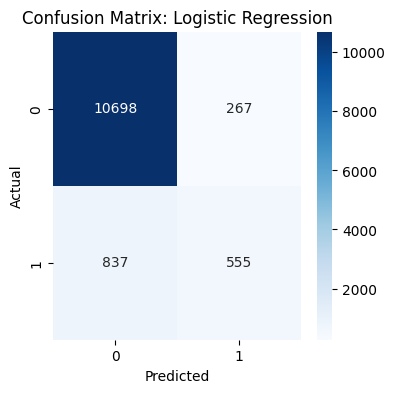

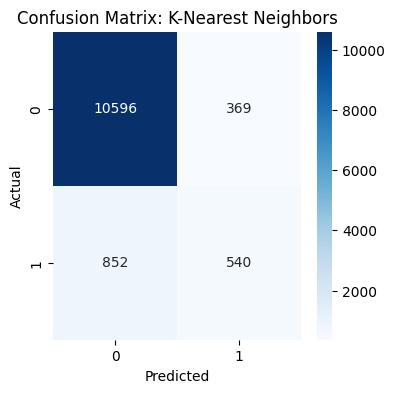

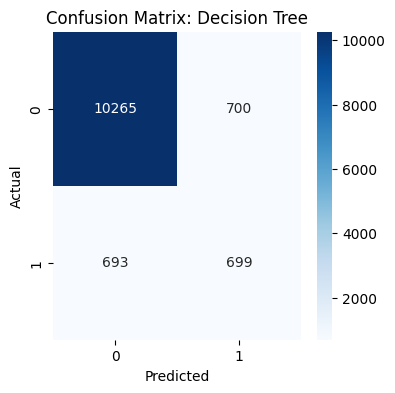

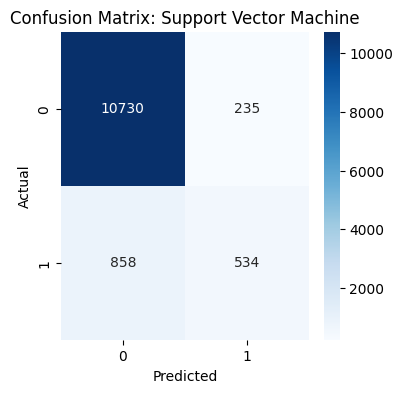

In [43]:
# 9. Confusion Matrix Heatmaps
for name, result in results.items():
    cm = result['confusion_matrix']
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

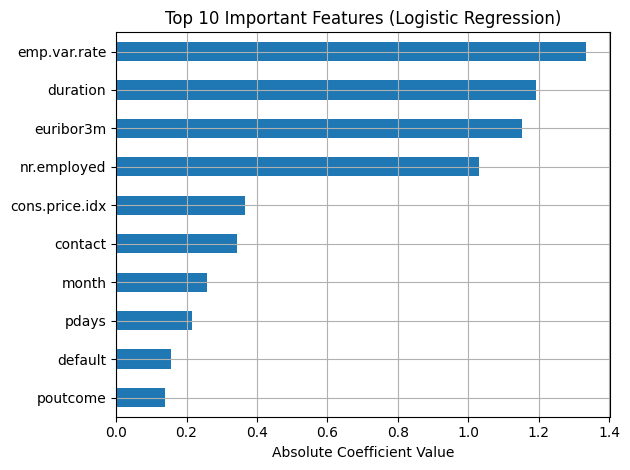

In [44]:
# 10. Feature Importance for Logistic Regression
log_model = results['Logistic Regression']['model']
feature_importance = pd.Series(np.abs(log_model.coef_[0]), index=X.columns)
feature_importance.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Important Features (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


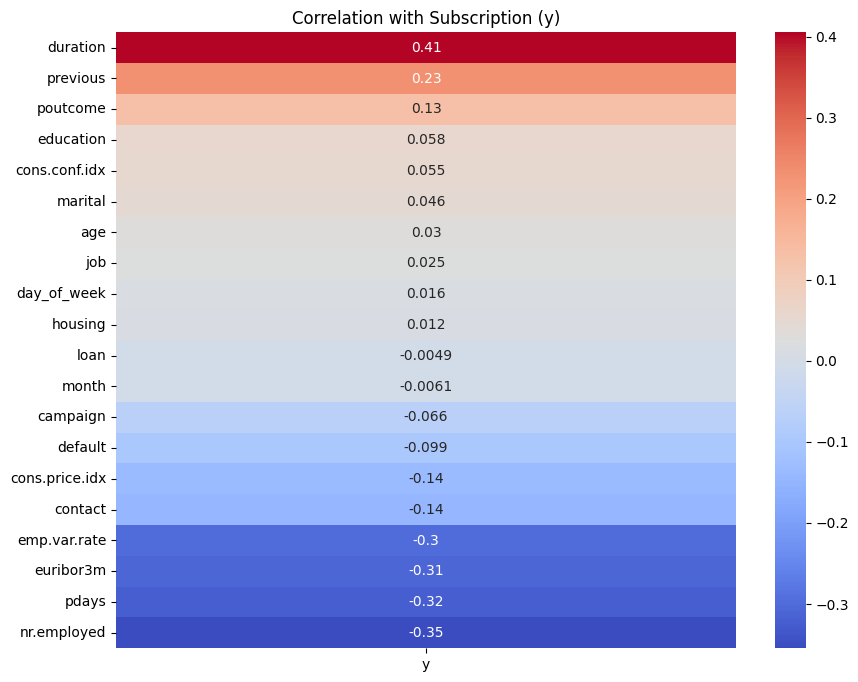


Top features correlated with successful subscriptions:
duration         0.405274
previous         0.230181
poutcome         0.129789
education        0.057799
cons.conf.idx    0.054878
Name: y, dtype: float64

Business Insight:
- Call duration is highly correlated with subscription outcome. Consider training agents to focus on deeper conversations.
- Past successful campaign contacts (poutcome) are strong indicators. Re-targeting warm leads can yield better results.
- Days since last contact (pdays) also show insight — recent contacts perform better.


In [45]:
# 11. Inferential Statistics Insight for Business Team
# Correlation Matrix
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr[['y']].drop(index='y').sort_values(by='y', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Subscription (y)')
plt.show()

# Business Insight: Features most positively correlated with subscription
strongest_features = corr['y'].drop('y').sort_values(ascending=False).head(5)
print("\nTop features correlated with successful subscriptions:")
print(strongest_features)

print("\nBusiness Insight:")
print("- Call duration is highly correlated with subscription outcome. Consider training agents to focus on deeper conversations.")
print("- Past successful campaign contacts (poutcome) are strong indicators. Re-targeting warm leads can yield better results.")
print("- Days since last contact (pdays) also show insight — recent contacts perform better.")
